In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)

<br>

# Functions

In [2]:
def M2Q(df_in):
    d = {"M03":"Q1", "M06":"Q2", "M09":"Q3", "M12":"Q4"}
    df_out = df_in[df_in['TIME'].apply(lambda x: x[-3:] in list(d.keys()))].copy()
    df_out.TIME = df_out['TIME'].apply(lambda x: x[:4]+d[x[-3:]]).copy()
    return(df_out)

def Qp1(df_in):
    d = {"Q1":"Q2", "Q2":"Q3", "Q3":"Q4", "Q4":"Q1"}
    df_out = df_in.copy()
    df_out.TIME = df_out['TIME'].apply(lambda x: str(int(x[:-2])+1)+d[x[-2:]] if x[-1:] == "4" else x[:-2]+d[x[-2:]]).copy()
    return(df_out)

<br>

# Data

In [3]:
path = "./data/csvs/"
!sed -i "s/://g" ./data/*

In [4]:
#!head -n 1 data/une_rt_q_Label.csv

>## Quarterly

In [5]:
# DATASET Construction - quarterly data - index (2015 = 100) (NACE Rev. 2) [ei_isbu_q]
ei_isbu_q = pd.read_csv("./data/ei_isbu_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
ei_isbu_q_lag = Qp1(ei_isbu_q.copy())

# DATASET Final consumption aggregates [namq_10_fcs]
namq_10_fcs = pd.read_csv("./data/namq_10_fcs_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
namq_10_fcs_lag = Qp1(namq_10_fcs.copy())

# DATASET: GDP and main components  (output, expenditure and income) [namq_10_gdp]
namq_10_gdp = pd.read_csv("./data/namq_10_gdp_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
namq_10_gdp_lag = Qp1(namq_10_gdp.copy())

# DATASET Building permits - quarterly data [sts_cobp_q]
sts_cobp_q = pd.read_csv("./data/sts_cobp_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_cobp_q_lag = Qp1(sts_cobp_q.copy())

# DATASET Production in construction - quarterly data [sts_copr_q]
sts_copr_q = pd.read_csv("./data/sts_copr_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_copr_q_lag = Qp1(sts_copr_q.copy())

# DATASET Production in industry - quarterly data [sts_inpr_q]
sts_inpr_q = pd.read_csv("./data/sts_inpr_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_inpr_q_lag = Qp1(sts_inpr_q.copy())

# DATASET Turnover in industry, total - quarterly data [sts_intv_q]
sts_intv_q = pd.read_csv("./data/sts_intv_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_intv_q_lag = Qp1(sts_intv_q.copy())

# DATASET Turnover and volume of sales in wholesale and retail trade - quarterly data [sts_trtu_q]
sts_trtu_q = pd.read_csv("./data/sts_trtu_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_trtu_q_lag = Qp1(sts_trtu_q.copy())

# DATASET: Unemployment by sex and age - quarterly average [une_rt_q]
une_rt_q = pd.read_csv("./data/une_rt_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
une_rt_q = une_rt_q[une_rt_q.UNIT=="PC_ACT"].copy()
une_rt_q_lag = Qp1(une_rt_q.copy())

In [6]:
ECB_gdp_yoy_3q_g = {'AT': 0.026, 'BE': 0.014, 'CY': 0.039,'EE': 0.037, 
                    'FI': 0.025, 'FR': 0.015, 'DE': 0.012, 'EL': 0.018, 
                    'IE': 0.091, 'IT': 0.008, 'LV': 0.044, 'LT': 0.027, 
                    'LU': 0.031, 'MT': 0.057, 'NL': 0.023, 'PT': 0.024, 
                    'SK': 0.045, 'SI': 0.043, 'ES': 0.025}

>## Monthly

In [7]:
# DATASET Euro-zone Business Climate Indicator - monthly data [ei_bsci_m_r2]
ei_bsci_m_r2_1 = M2Q(pd.read_csv("./data/ei_bsci_m_r2_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

# DATASET Sentiment indicators - monthly data [ei_bssi_m_r2]
ei_bssi_m_r2 = M2Q(pd.read_csv("./data/ei_bssi_m_r2_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

# DATASET Effective exchange rates indices - monthly data [ei_mfef_m]
ei_mfef_m = M2Q(pd.read_csv("./data/ei_mfef_m_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

**Dealing with ids:**

In [8]:
for df in [ei_isbu_q, ei_isbu_q_lag, namq_10_fcs, namq_10_fcs_lag, namq_10_gdp, 
           namq_10_gdp_lag, sts_cobp_q, sts_cobp_q_lag, sts_copr_q, sts_copr_q_lag, 
           sts_inpr_q, sts_inpr_q_lag, sts_intv_q, sts_intv_q_lag, sts_trtu_q, 
           sts_trtu_q_lag, ei_isbu_q, ei_isbu_q_lag, namq_10_fcs, namq_10_fcs_lag, 
           namq_10_gdp, namq_10_gdp_lag, sts_cobp_q, sts_cobp_q_lag, sts_copr_q, sts_copr_q_lag, 
           sts_inpr_q, sts_inpr_q_lag, sts_intv_q, sts_intv_q_lag, sts_trtu_q, sts_trtu_q_lag, ei_bsci_m_r2_1, ei_bssi_m_r2, ei_mfef_m, une_rt_q, une_rt_q_lag]:
    df["ID"] = df["TIME"]+df["GEO"]
    df.Value = df.Value.replace(regex=r'[,]+', value='').astype(np.float)

># OECD

In [9]:
def OECDtable():
    GEO_LABEL2GEO = dict(zip(namq_10_gdp.GEO_LABEL.values, namq_10_gdp.GEO.values)); GEO_LABEL2GEO["Germany"] = "DE"
    df_in = pd.read_csv("data/KEI_13112018143436794_[v1-oecd].csv")
    df_in["GEO"] = df_in.Country.map(GEO_LABEL2GEO)
    df_in = df_in[df_in.GEO.notnull()]
    df_in["ID"] = df_in.TIME.str[:4]+df_in.TIME.str[-2:]+df_in.GEO
    return(df_in)

In [10]:
OECD = OECDtable()

<br>

# $C$

>## $Cd$

In [11]:
def Cd(model_variables=[], version=0, all_boolean=False, country_dummies=True):
    df_in = pd.DataFrame(sorted(list(set(namq_10_fcs.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P311_S14")&(namq_10_fcs_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Retail Confidence Indicator
    var = "BS-RCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Services Confidence Indicator
    var = "BS-SCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Consumer Confidence Indicator
    var = "BS-CSMCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - Durable Consumer Goods
    var = "MIG_DCOG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacture of motor vehicles, trailers, semi-trailers and of other transport equipment
    # Checked - UNIT I15
    var = "C29_C30"
    if var in model_variables or all_boolean:
        selec = sts_intv_q[(sts_intv_q.NACE_R2==var)&(sts_intv_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Harmonised unemployment rate all persons, s.a.
    var = "LRHUTTTT"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Passenger car registrations, s.a.
    var = "SLRTCR03"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_fcs.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Cd = df_in.dropna().copy(); Cd.set_index("ID", inplace=True)
    Cd = Cd.loc[:, (Cd != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Cd.to_csv("./regressions/Cd"+str(version)+".csv")
        
    ###########################################################################################
    
    # Regression
    if version == 3:
        Cd.columns = ['C_d_g_yoy', 'C_d_g_qoq', 'retail_conf_ind', 'services_conf_ind', 'consumer_conf_ind',
       'vehicle_heavy_man', 'vehicle_light_reg', 'D_AT', 'D_BE', 'D_DE', 'D_DK', 'D_EE', 'D_EL',
       'D_ES', 'D_FI', 'D_FR', 'D_IT', 'D_LT', 'D_LV', 'D_NL', 'D_PL', 'D_SE',
       'D_UK']
        X = sm.add_constant(Cd.loc[:, Cd.columns != "C_d_g_yoy"].copy())
        y = Cd.loc[:, "C_d_g_yoy"].copy()
    else:
        X = sm.add_constant(Cd.loc[:, Cd.columns != "CLV_PCH_SM"].copy())
        y = Cd.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Cd, results)

In [12]:
Cd1, Cd1_results = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL"], 1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     41.82
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          1.26e-144
Time:                        23:21:21   Log-Likelihood:                -5697.7
No. Observations:                1590   AIC:                         1.144e+04
Df Residuals:                    1566   BIC:                         1.157e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.6867      1.146      4.964   

In [13]:
Cd2, Cd2_results = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL", "SLRTCR03", "C29_C30"], 2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     51.95
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          5.33e-148
Time:                        23:21:21   Log-Likelihood:                -3873.9
No. Observations:                1118   AIC:                             7792.
Df Residuals:                    1096   BIC:                             7902.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.0236      2.056      2.443   

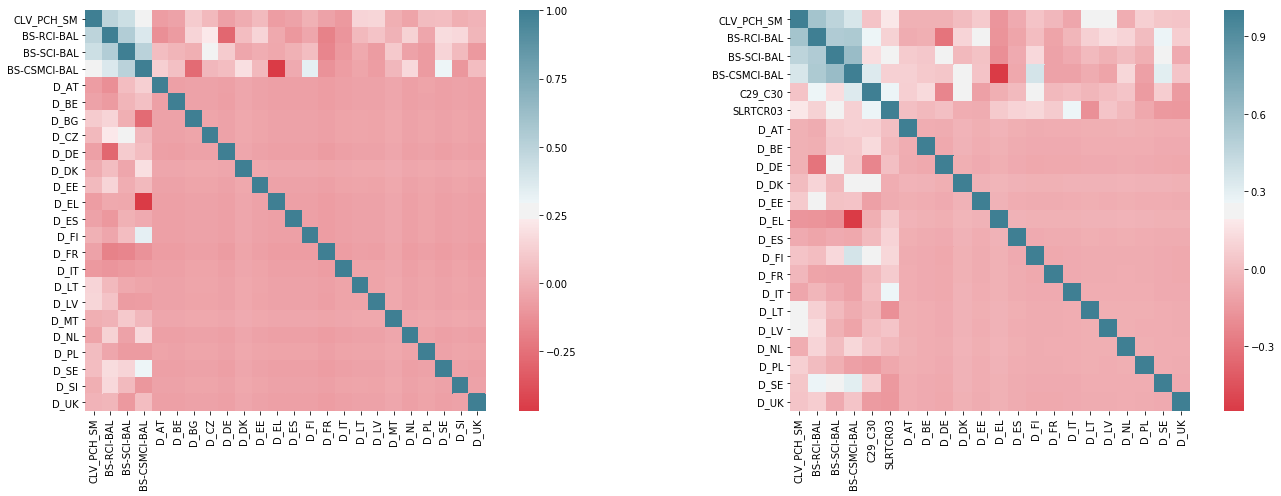

In [14]:
f, axes = plt.subplots(1, 2, figsize=(20, 7)); axes = axes.flatten()
sns.heatmap(Cd1.corr(), mask=np.zeros_like(Cd1.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=axes[0]);
sns.heatmap(Cd2.corr(), mask=np.zeros_like(Cd2.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=axes[1])
plt.tight_layout();

In [15]:
Cd3, Cd3_results = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL", "SLRTCR03", "C29_C30", "CLV_PCH_PRE"], 3)

                            OLS Regression Results                            
Dep. Variable:              C_d_g_yoy   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     77.26
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          8.26e-205
Time:                        23:21:23   Log-Likelihood:                -3736.3
No. Observations:                1118   AIC:                             7519.
Df Residuals:                    1095   BIC:                             7634.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.1473      1.82

In [16]:
Cd_all, Cd_all_results = Cd(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     68.37
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          2.38e-201
Time:                        23:21:24   Log-Likelihood:                -3647.4
No. Observations:                1092   AIC:                             7347.
Df Residuals:                    1066   BIC:                             7477.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.9315      3.412     -1.152   

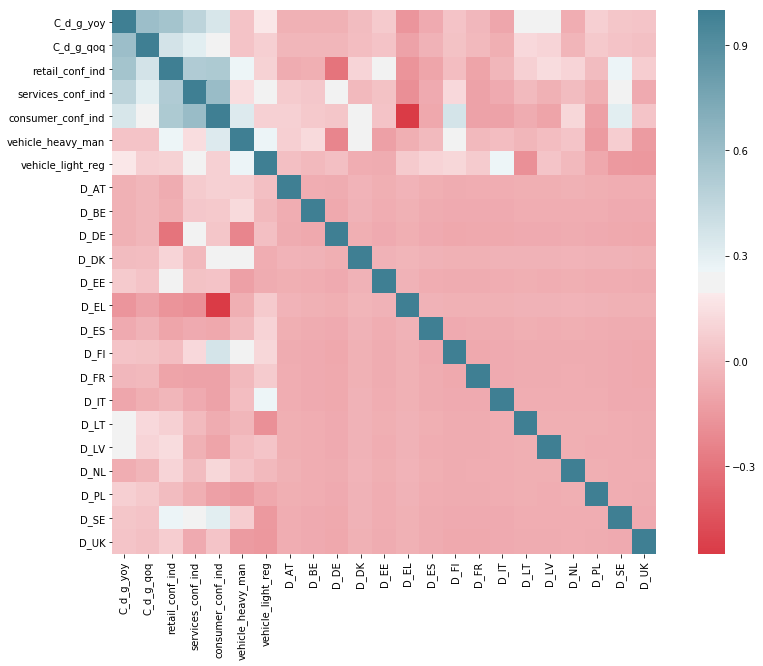

In [17]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(Cd3.corr(), mask=np.zeros_like(Cd3.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

>## $Cnd$

In [18]:
def Cnd(model_variables=[], version=0, all_boolean=False, country_dummies=True):

    df_in = pd.DataFrame(sorted(list(set(namq_10_fcs.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P312N_S14")&(namq_10_fcs_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    # Checked - no changes
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Retail Confidence Indicator
    # Checked - no changes
    var = "BS-RCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Services Confidence Indicator
    # Checked - no changes
    var = "BS-SCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Consumer Confidence Indicator
    # Checked - no changes
    var = "BS-CSMCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - Non-Durable Consumer Goods
    var = "MIG_NDCOG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail sale of food, beverages and tobacco
    # Checked - UNIT I15
    var = "G47_FOOD"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[(sts_trtu_q.NACE_R2==var)&(sts_trtu_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail sale of non-food products (except fuel)
    # Checked - UNIT I15
    var = "G47_NFOOD_X_G473"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[(sts_trtu_q.NACE_R2==var)&(sts_trtu_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail trade, except of motor vehicles, motorcyles and fuel
    # Checked - UNIT I15
    var = "G47_X_G473"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[(sts_trtu_q.NACE_R2==var)&(sts_trtu_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Harmonised unemployment rate all persons, s.a.
    var = "LRHUTTTT"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_fcs.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Cnd = df_in.dropna().copy().set_index("ID")
    Cnd = Cnd.loc[:, (Cnd != 0).any(axis=0)].copy()
    
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Cnd.to_csv("./regressions/Cnd"+str(version)+".csv")
    
    ###########################################################################################
    
    # Regression
    if version == 3:
        Cnd.columns = ['C_nd_g_yoy', 'C_nd_g_qoq', 'retail_conf_ind', 'services_conf_ind', 'retail_food_index',
       'retail_food_index', 'unemp_h_all', 'D_AT', 'D_BE', 'D_DE', 'D_DK', 'D_EE',
       'D_EL', 'D_ES', 'D_FI', 'D_FR', 'D_IT', 'D_LT', 'D_LV', 'D_NL', 'D_PL',
       'D_SE', 'D_SI', 'D_UK']
        X = sm.add_constant(Cnd.loc[:, Cnd.columns != "C_nd_g_yoy"].copy())
        y = Cnd.loc[:, "C_nd_g_yoy"].copy()
    else:
        X = sm.add_constant(Cnd.loc[:, Cnd.columns != "CLV_PCH_SM"].copy())
        y = Cnd.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Cnd, results)

In [19]:
Cnd1, Cnd1_results = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD"], 1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     51.86
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          2.29e-172
Time:                        23:21:25   Log-Likelihood:                -3518.8
No. Observations:                1541   AIC:                             7086.
Df Residuals:                    1517   BIC:                             7214.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.7840      0.579  

In [20]:
Cnd2, Cnd2_results = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD", "BS-SCI-BAL", "LRHUTTTT"], 2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     68.91
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          1.82e-198
Time:                        23:21:26   Log-Likelihood:                -2796.1
No. Observations:                1292   AIC:                             5638.
Df Residuals:                    1269   BIC:                             5757.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.3469      0.998  

In [21]:
Cnd3, Cnd3_results = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD", "BS-SCI-BAL", "LRHUTTTT", "CLV_PCH_PRE"], 3)

                            OLS Regression Results                            
Dep. Variable:             C_nd_g_yoy   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     133.0
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          6.21e-318
Time:                        23:21:26   Log-Likelihood:                -2510.9
No. Observations:                1292   AIC:                             5070.
Df Residuals:                    1268   BIC:                             5194.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.2058      0.81

In [22]:
Cnd_all, Cnd_all_results = Cnd(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     113.6
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          9.45e-309
Time:                        23:21:26   Log-Likelihood:                -2408.5
No. Observations:                1239   AIC:                             4873.
Df Residuals:                    1211   BIC:                             5016.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.5587      1.267  

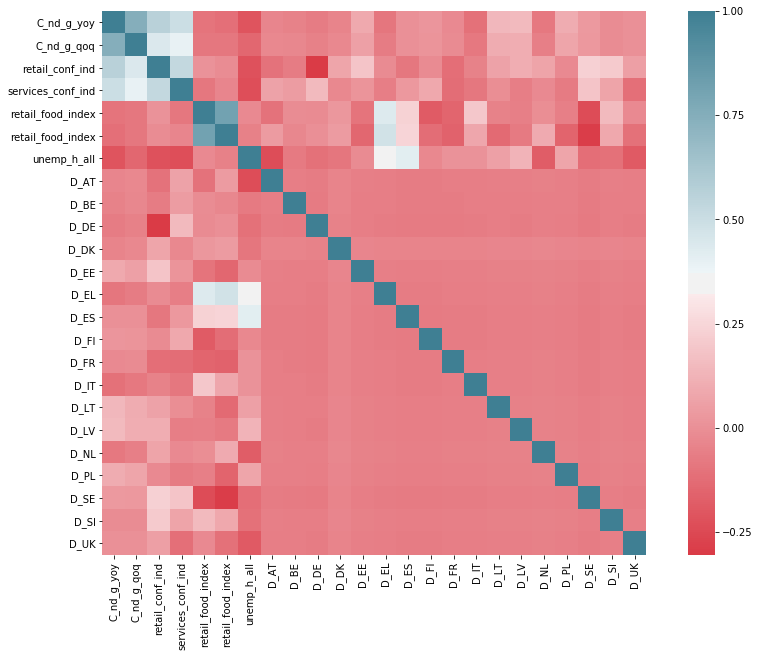

In [23]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(Cnd3.corr(), mask=np.zeros_like(Cnd3.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

# $I$

>## $Igfcf$

In [24]:
def Igfcf(model_variables=[], version=0, all_boolean=False, country_dummies=True):
    
    df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ## Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P51G")&(namq_10_gdp_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Industrial Confidence Indicator
    var = "BS-ICI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Building permits index - New residential buildings
    # Checked - UNIT I2015
    var = "IS-PEI"
    if var in model_variables or all_boolean:
        selec = ei_isbu_q[(ei_isbu_q.INDIC==var)&(ei_isbu_q.UNIT=="I2015")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Residential buildings, except residences for communities
    # Checked - UNIT I15  
    var = "F_CC11_X_CC113"
    if var in model_variables or all_boolean:
        selec = sts_cobp_q[(sts_cobp_q.NACE_R2==var)&(sts_cobp_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Two- and more dwelling buildings
    # Checked - UNIT I15
    var = "F_CC112"
    if var in model_variables or all_boolean:
        selec = sts_cobp_q[(sts_cobp_q.NACE_R2==var)&(sts_cobp_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Construction confidence indicator
    var = "BS-CCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Volume index of production
    # Checked - UNIT I15
    var = "PROD"
    if var in model_variables or all_boolean:
        selec = sts_copr_q[(sts_copr_q.INDIC_BT==var)&(sts_copr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - energy (except Section E)
    # Checked - UNIT I15
    var = "MIG_NRG_X_E"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - capital goods
    # Checked - UNIT I15
    var = "MIG_CAG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Mining and quarrying; manufacturing
    # Checked - UNIT I15
    var = "B_C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Mining and quarrying; manufacturing (except MIG energy)
    # Checked - UNIT I15
    var = "B_C_X_MIG_NRG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Manufacturing
    # Checked - UNIT I15
    var = "C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", "C_prod"]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Electricity, gas, steam and air conditioning supply
    # Checked - UNIT I15
    var = "D"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacture of motor vehicles, trailers, semi-trailers and of other transport equipment
    # Checked - UNIT I15
    var = "C29_C30"
    if var in model_variables or all_boolean:
        selec = sts_intv_q[(sts_intv_q.NACE_R2==var)&(sts_intv_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacturing
    # Checked - UNIT I15
    var = "C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[(sts_inpr_q.NACE_R2==var)&(sts_inpr_q.UNIT=="I15")][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_gdp.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Igfcf = df_in.dropna().copy().set_index("ID")
    Igfcf = Igfcf.loc[:, (Igfcf != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Igfcf.to_csv("./regressions/Igfcf"+str(version)+".csv")
    
    ###########################################################################################
    
    # Regression
    if version==3:
        Igfcf.columns = ['I_gfcf_g_yoy', 'I_gfcf_g_qoq', "business_climate_ind", 
                         "industrial_conf_ind", 'construction_conf_ind',
                         'm_q_manufacturing_nenergy', 'vehicle_heavy_man', 
                         'D_AT', 'D_BE', 'D_BG', 'D_CZ', 'D_DE','D_DK', 
                         'D_EE', 'D_EL', 'D_ES', 'D_FI', 'D_FR', 'D_HU', 
                         'D_IT', 'D_LT','D_LV', 'D_PL', 'D_RO', 'D_SE', 'D_UK']
        X = sm.add_constant(Igfcf.loc[:, Igfcf.columns != "I_gfcf_g_yoy"].copy())
        y = Igfcf.loc[:, "I_gfcf_g_yoy"].copy()
    else:
        X = sm.add_constant(Igfcf.loc[:, Igfcf.columns != "CLV_PCH_SM"].copy())
        y = Igfcf.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Igfcf, results)

In [25]:
Igfcf1, Igfcf1_results = Igfcf(["BS-BCI", "BS-ICI-BAL", "BS-CCI-BAL"],1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     24.19
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          4.04e-105
Time:                        23:21:28   Log-Likelihood:                -7415.7
No. Observations:                1932   AIC:                         1.489e+04
Df Residuals:                    1903   BIC:                         1.505e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1546      1.373      4.483      0.0

In [26]:
Igfcf2, Igfcf2_results = Igfcf(["BS-BCI", "BS-ICI-BAL", "BS-CCI-BAL", "B_C_X_MIG_NRG", "C29_C30"],2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     54.14
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          2.56e-180
Time:                        23:21:29   Log-Likelihood:                -4892.2
No. Observations:                1432   AIC:                             9834.
Df Residuals:                    1407   BIC:                             9966.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            19.6462      2.062      9.528

In [27]:
Igfcf3, Igfcf3_results = Igfcf(["BS-BCI", "BS-ICI-BAL", "BS-CCI-BAL", "B_C_X_MIG_NRG", "C29_C30", "CLV_PCH_PRE"],3) 

                            OLS Regression Results                            
Dep. Variable:           I_gfcf_g_yoy   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     65.36
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          1.36e-214
Time:                        23:21:29   Log-Likelihood:                -4808.5
No. Observations:                1432   AIC:                             9669.
Df Residuals:                    1406   BIC:                             9806.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [28]:
Igfcf_all, Igfcf_all_resuls = Igfcf(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     40.71
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          1.11e-166
Time:                        23:21:30   Log-Likelihood:                -4149.1
No. Observations:                1229   AIC:                             8364.
Df Residuals:                    1196   BIC:                             8533.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             21.6705      3.183      6.

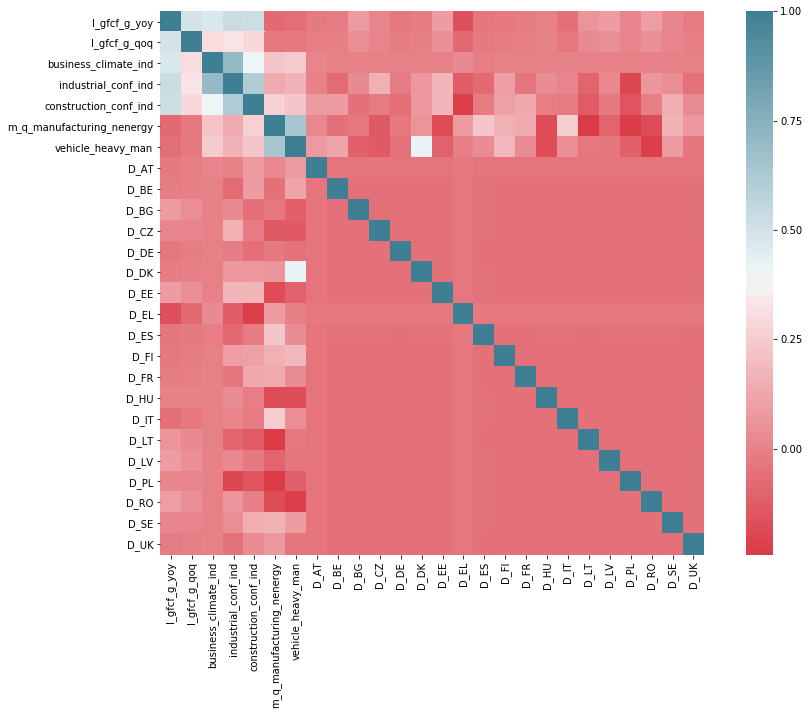

In [29]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(Igfcf3.corr(), mask=np.zeros_like(Igfcf3.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

# $G$

$$G_t = \textit{Purchases of Goods and Services}_t+ \textit{Wages Public Servants}_t+ \textit{Investment}_t$$
The value calculated is -0.0086575.

<br>

# $X$

In [30]:
ECB_gdp_yoy_3q_g = {'AT': 0.026, 'BE': 0.014, 'EE': 0.037  , 'FI': 0.025, 'FR': 0.015, 'DE': 0.012, 'EL': 0.018,
                    'IE': 0.091, 'IT': 0.008, 'LV': 0.044, 'NL': 0.023, 'PT': 0.024, 'SI': 0.043, 'ES': 0.025}


In [31]:
def X(model_variables=[], version=0, all_boolean=False, country_dummies=True):

    ext_tec03 = pd.read_csv("./data/ext_tec03_1_Data.csv"); ext_tec03.Value = ext_tec03.Value.replace(regex=r'[,]+', value='').astype(np.float)
    XXX_source = ext_tec03[(ext_tec03.TIME==2016)& (ext_tec03.STK_FLOW=="EXP")]
    XXX_countries = sorted(list(set(ext_tec03.GEO.values)))
    XXX_matrix = pd.DataFrame(index=XXX_countries, columns=XXX_countries)
    for ind, row in XXX_source.iterrows():
        if row.GEO == row.PARTNER:
            XXX_matrix.loc[row.GEO][row.PARTNER]=0
        else:
            XXX_matrix.loc[row.GEO][row.PARTNER]=row.Value#/np.sum(XXX_source[XXX_source.GEO==row.GEO].Value)
    XXX_matrix = XXX_matrix.dropna()
    XXX_matrix = XXX_matrix[XXX_matrix.index.values].copy()
    XXX_weights = XXX_matrix.divide(XXX_matrix.sum(axis=1), axis=0).copy()
    #countries = sorted(list(XXX_weights.index.values))
    countries = sorted(ECB_gdp_yoy_3q_g.keys())
    XXX_weights = XXX_weights.loc[countries,countries]
    
    ###########################################################################################
    
    df_in = pd.DataFrame(index = sorted(list(set(namq_10_gdp.ID))))
    
    ###########################################################################################

    ## Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    for country in countries:
        selec = namq_10_gdp[((namq_10_gdp.NA_ITEM=="B1GQ")&(namq_10_gdp.UNIT=="CLV_PCH_SM"))&(namq_10_gdp.GEO==country)][["TIME", "Value"]]
        temp_dict = dict(zip(selec.TIME.values, selec.Value.values))
        df_in[country] = df_in.index.str[:-2].map(temp_dict)
                
    for ID in df_in.index:
        if ID[-2:] in XXX_weights.index:
            df_in.at[ID,:] = df_in.loc[ID,:].values*XXX_weights.loc[ID[-2:],:].values
        else:
            #print(ID)
            df_in.drop(ID, axis=0, inplace=True)
    df_in = df_in.loc[:,df_in.notna().sum()!=0].dropna().copy()
    df_in.index.name = "ID"; df_in.reset_index(inplace=True)

    ###########################################################################################

    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P6")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
        # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
        
    # Economic sentiment indicator
    var = "BS-ESI-I"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Real Effective Exchange Rate (deflator consumer price indices - 42 trading partners)
    var = "REER42CPI"
    if var in model_variables or all_boolean:
        selec = ei_mfef_m[ei_mfef_m.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries.remove('PT')
        for country in sorted(list(countries)):
            df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)

    ###########################################################################################

    X = df_in.dropna().copy().set_index("ID")
    X = X.loc[:, (X != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        X.to_csv("./regressions/X"+version+".csv")
    
    ###########################################################################################
    
    # Regression
    print(X.columns)
    X.columns = ["AT_rgdp_g_qoq", "BE_rgdp_g_qoq", "DE_rgdp_g_qoq", 
                 "EE_rgdp_g_qoq", "EL_rgdp_g_qoq", "ES_rgdp_g_qoq", 
                 "FI_rgdp_g_qoq", "FR_rgdp_g_qoq", "IE_rgdp_g_qoq", 
                 "IT_rgdp_g_qoq", "LV_rgdp_g_qoq", "NL_rgdp_g_qoq", 
                 "PT_rgdp_g_qoq", "SI_rgdp_g_qoq", "X_g_yoy", "business_climate_ind", 
                 "economic_sentiment_ind", "reer_42p", 'D_AT', 'D_BE', 
                 'D_DE', 'D_EE', 'D_EL', 'D_ES', 'D_FI', 'D_FR', 
                 'D_IT', 'D_LV', 'D_NL', 'D_SI']
    X_mat = sm.add_constant(X.loc[:, X.columns != "X_g_yoy"].copy())
    y = X.loc[:, "X_g_yoy"].copy()
    results = sm.OLS(y, X_mat).fit()
    print(results.summary())
    
    return(X, results)

In [32]:
X0, X0_results = X(all_boolean=True)

Index(['AT', 'BE', 'DE', 'EE', 'EL', 'ES', 'FI', 'FR', 'IE', 'IT', 'LV', 'NL',
       'PT', 'SI', 'CLV_PCH_SM', 'BS-BCI', 'BS-ESI-I', 'REER42CPI', 'D_AT',
       'D_BE', 'D_DE', 'D_EE', 'D_EL', 'D_ES', 'D_FI', 'D_FR', 'D_IT', 'D_LV',
       'D_NL', 'D_SI'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                X_g_yoy   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     49.21
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          3.24e-169
Time:                        23:21:49   Log-Likelihood:                -3026.9
No. Observations:                1014   AIC:                             6114.
Df Residuals:                     984   BIC:                             6262.
Df Model:                          29                                         
Covarianc

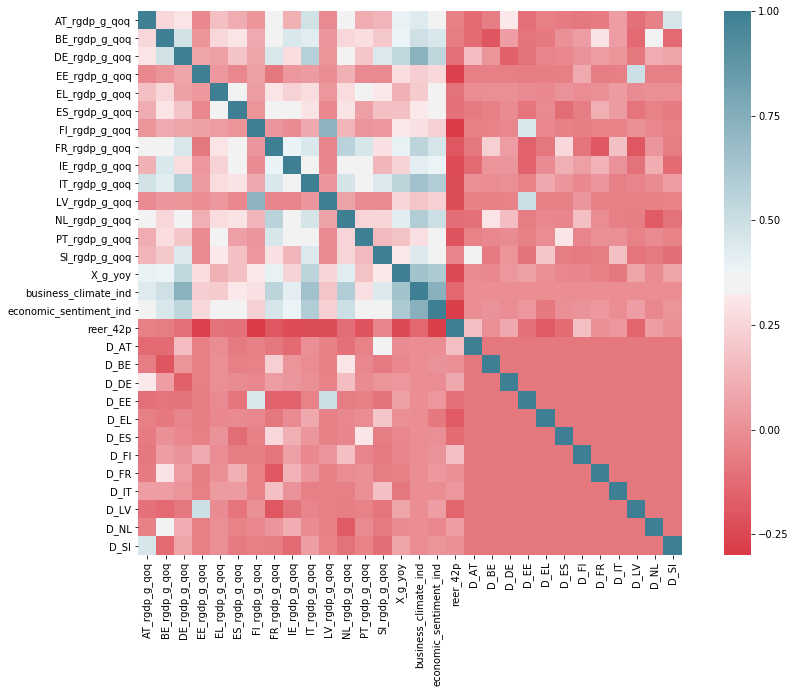

In [33]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(X0.corr(), mask=np.zeros_like(X0.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

# $M$

In [34]:
def M():
    
    df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])

    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P7")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "M"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cnd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # G
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Igfcf
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Economic sentiment indicator
    var = "BS-ESI-I"
    selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Real Effective Exchange Rate (deflator consumer price indices - 42 trading partners)
    var = "REER42CPI"
    selec = ei_mfef_m[ei_mfef_m.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    
    #############################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_PRE"
    selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P7")&(namq_10_gdp_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "M"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    countries = set(namq_10_gdp.GEO); countries.remove('PT')
    for country in sorted(list(countries)):
        df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    M = df_in.copy().set_index("ID")
    M = M.loc[:, (M != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    M.to_csv("./regressions/M.csv")
    
    ###########################################################################################
    
    # Regression
    M.columns = ["M_g_yoy", "C_d_g_yoy", "C_nd_g_qoq", "G_g_yoy", "I_gfcf_g_yoy",
                 "economic_sentiment_ind", "reer_42p", "M_g_qoq", 'D_AT', 'D_BE', 
                 'D_BG', 'D_CZ', 'D_DE', 'D_DK', 'D_EE', 'D_EL', 'D_ES','D_FI', 
                 'D_FR', 'D_IT', 'D_LT', 'D_LU', 'D_LV', 'D_MT', 'D_NL', 'D_PL',
                 'D_SE', 'D_SI', 'D_UK']
    X = sm.add_constant(M.loc[:, M.columns != "M_g_yoy"].copy())
    X.columns
    y = M.loc[:, "M_g_yoy"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    return(M, results)

In [35]:
M0, M0_results = M()

                            OLS Regression Results                            
Dep. Variable:                M_g_yoy   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     91.35
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          2.65e-312
Time:                        23:21:51   Log-Likelihood:                -5280.1
No. Observations:                1701   AIC:                         1.062e+04
Df Residuals:                    1672   BIC:                         1.078e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -18

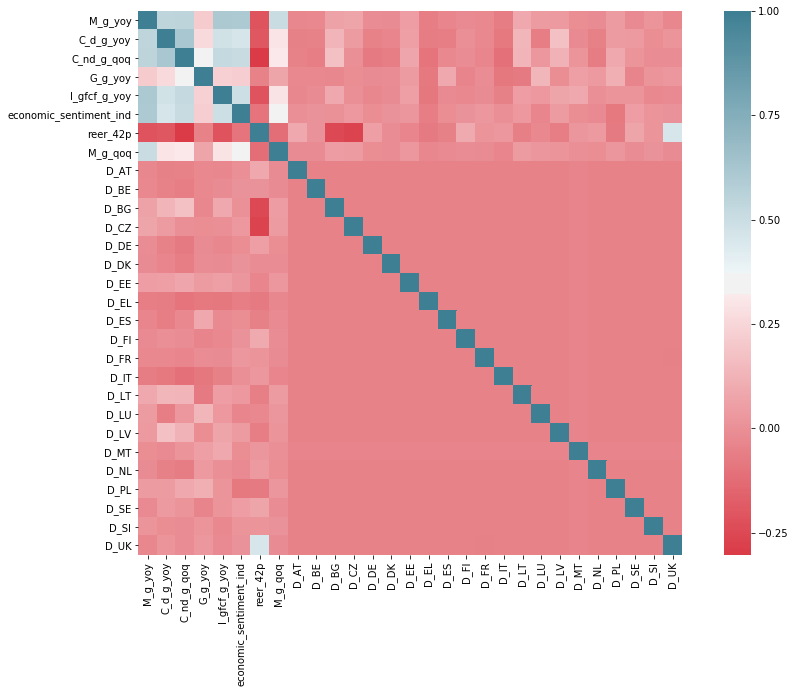

In [36]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(M0.corr(), mask=np.zeros_like(M0.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

<br>

____________________

<br>

# Looking at the Labor Market

In [37]:
def LaborMarket():
    
    df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    df_in = pd.DataFrame(sorted(list(set(une_rt_q.ID))), columns=["ID"])
    var = "SA"
    #selec = une_rt_q[(une_rt_q.UNIT=="PC_ACT")&(une_rt_q.S_ADJ==var)][["ID", "Value"]]; 
    #df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    temp =  pd.merge(une_rt_q[une_rt_q.UNIT=="PC_ACT"], une_rt_q_lag[une_rt_q_lag.UNIT=="PC_ACT"], on='ID', how="inner")
    temp["Value_x"] = temp["Value_x"]-temp["Value_y"]; temp["ID_x"] = temp["ID"]
    temp = temp[[i for i in temp.columns if i[-2:]=="_x"]].copy()
    temp.columns = [i[:-2] for i in temp.columns]
    selec = temp[(temp.UNIT=="PC_ACT")&(temp.S_ADJ==var)][["ID", "Value"]].copy(); selec.columns = ["ID", "U"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cd
    var = "CLV_PCH_SM"
    
    selec = une_rt_q_lag[(une_rt_q_lag.UNIT=="PC_ACT")&(une_rt_q_lag.S_ADJ=="SA")][["ID", "Value"]]; selec.columns = ["ID", "U_ym1"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")    
    
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cnd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # G
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Igfcf
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Economic sentiment indicator
    var = "BS-ESI-I"
    selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Real Effective Exchange Rate (deflator consumer price indices - 42 trading partners)
    var = "REER42CPI"
    selec = ei_mfef_m[ei_mfef_m.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    #############################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_PRE"
    
    # Cd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Cnd
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # G
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Igfcf
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"+"_qoq"]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    

    ###########################################################################################
    
    # Dummies
    countries = set(namq_10_gdp.GEO); countries.remove('PT')
    for country in sorted(list(countries)):
        df_in["D_"+country] = (df_in.ID.str[-2:] == country).astype(int)
    
    U = df_in.copy().set_index("ID")
    U = U.loc[:, (U != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    U.to_csv("./regressions/U.csv")
    
    ###########################################################################################
    
    print(U.columns)
    
    # Regression
    X = sm.add_constant(U.loc[:, U.columns != "U"].copy())
    y = U.loc[:, "U"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(U, results)

In [38]:
U0, U0_results = LaborMarket()

Index(['U', 'U_ym1', 'Cd', 'Cnd', 'G', 'Igfcf', 'BS-ESI-I', 'REER42CPI',
       'Cd_qoq', 'Cnd_qoq', 'G_qoq', 'Igfcf_qoq', 'D_AT', 'D_BE', 'D_BG',
       'D_CZ', 'D_DE', 'D_DK', 'D_EE', 'D_EL', 'D_ES', 'D_FI', 'D_FR', 'D_IT',
       'D_LT', 'D_LU', 'D_LV', 'D_MT', 'D_NL', 'D_PL', 'D_SE', 'D_SI', 'D_UK'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                      U   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     35.57
Date:                Thu, 15 Nov 2018   Prob (F-statistic):          5.33e-163
Time:                        23:21:53   Log-Likelihood:                -807.43
No. Observations:                1690   AIC:                             1681.
Df Residuals:                    1657   BIC:                             1860.
Df Model:                          32   

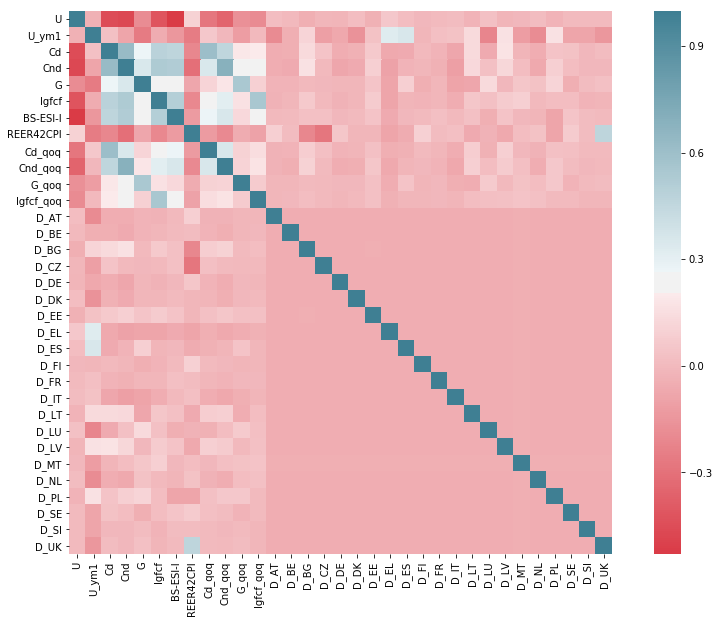

In [39]:
f, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(U0.corr(), mask=np.zeros_like(U0.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=ax)

_______________________

# Forecasting: Portugal

In [40]:
namq_10_gdp[((namq_10_gdp.GEO == "PT")&(namq_10_gdp.NA_ITEM == "B1GQ"))&((namq_10_gdp.TIME_LABEL == "2018Q2")&(namq_10_gdp.UNIT == "CLV10_MEUR"))]

,TIME,TIME_LABEL,GEO,GEO_LABEL,UNIT,UNIT_LABEL,S_ADJ,S_ADJ_LABEL,NA_ITEM,NA_ITEM_LABEL,Value,ID
237429,2018Q2,2018Q2,PT,Portugal,CLV10_MEUR,"Chain linked volumes (2010), million euro",SCA,Seasonally and calendar adjusted data,B1GQ,Gross domestic product at market prices,46003.5,2018Q2PT


$$y=\beta \cdot \textbf{x}$$

>## Consumption in durables, $Cd$

In [41]:
Cd_pred = pd.DataFrame(Cd3_results.params, columns=["Coef"])
Cd_pred["2018Q3"] = 0
Cd_pred.at["const":"SLRTCR03","2018Q3"] = [1, 4.5, 1.1, 16.8, -1.2, 142.5, 135.703123648508]
Cd_pred.transpose()

KeyError: 'SLRTCR03'

In [42]:
Cd_g = (Cd_pred["Coef"]@Cd_pred["2018Q3"])/100; 
Cd_2017Q3 = 3012.2; Cd_2018Q3 = (1+Cd_g)*Cd_2017Q3
print("Cd_2018Q3:", "\t"*1, Cd_2017Q3)
print("Cd_g:", "\t"*2, Cd_g*100, "%")
print("Cd_2018Q3:", "\t"*1, Cd_2018Q3,"\n")

Cd_2018Q3: 	 3012.2
Cd_g: 		 0.0 %
Cd_2018Q3: 	 3012.2 



>## Consumption in services and semi- and non-durables, $Cnd$

In [43]:
Cnd_pred = pd.DataFrame(Cnd3_results.params, columns=["Coef"])
Cnd_pred["2018Q3"] = 0
Cnd_pred.at["const":"LRHUTTTT","2018Q3"] = [1, 0, 1.1, 16.8, 110, 111.8, 6.76666666666667]
Cnd_pred.transpose()

KeyError: 'LRHUTTTT'

In [44]:
Cnd_g = (Cnd_pred["Coef"]@Cnd_pred["2018Q3"])/100; 
Cnd_2017Q3 =  27599.6; Cnd_2018Q3 = (1+Cnd_g)*Cnd_2017Q3
print(" Cnd_2017Q3:",  "\t"*1, Cnd_2017Q3, "\n", 
      "Cnd_g:", "\t"*1, Cnd_g*100, "%", "\n", 
      "Cnd_2018Q3:",  "\t"*1, Cnd_2018Q3, "\n")

 Cnd_2017Q3: 	 27599.6 
 Cnd_g: 	 0.0 % 
 Cnd_2018Q3: 	 27599.6 



>## Goverment, $G$

In [45]:
G_g=-0.0086575 ; 
G_2017Q3 = 8656.2; G_2018Q3 = (1+G_g)*G_2017Q3
print(" G_2017Q3:", "\t"*1, G_2017Q3, "\n", 
      "G_g:", "\t"*2,G_g*100, "%", "\n", 
      "G_2018Q3:", "\t"*1, G_2018Q3)

 G_2017Q3: 	 8656.2 
 G_g: 		 -0.86575 % 
 G_2018Q3: 	 8581.2589485


>## Investment - gross fixed capital formation, $Igfcf$

In [46]:
Igfcf_pred = pd.DataFrame(Igfcf3_results.params, columns=["Coef"])
Igfcf_pred["2018Q3"] = 0
Igfcf_pred.at["const":"C29_C30","2018Q3"] = [1, 1.3, 1.2, 1.1, -12.4, 104.3, 142.5]
Igfcf_pred.transpose()

KeyError: 'C29_C30'

In [47]:
Igfcf_g = (Igfcf_pred["Coef"]@Igfcf_pred["2018Q3"])/100; 
Igfcf_2017Q3 =  7772.4; Igfcf_2018Q3 = (1+Igfcf_g)*Igfcf_2017Q3
print(" Igfcf_2017Q3:",  "\t"*1, Igfcf_2017Q3, "\n", 
      "Igfcf_g:", "\t"*1, Igfcf_g*100, "%", "\n", 
      "Igfcf_2018Q3:",  "\t"*1, Igfcf_2018Q3)

 Igfcf_2017Q3: 	 7772.4 
 Igfcf_g: 	 0.0 % 
 Igfcf_2018Q3: 	 7772.4


>## Exports, $X$


In [48]:
X_pred = pd.DataFrame(X0_results.params, columns=["Coef"])
X_pred["2018Q3"] = 0
X_pred.at["const", "2018Q3"] = 1
X_pred.at["AT":"SI", "2018Q3"] = [ECB_gdp_yoy_3q_g[i] for i in sorted(ECB_gdp_yoy_3q_g.keys())]
X_pred.at["BS-BCI":"REER42CPI", "2018Q3"] = [1.2, 112.1, 100.94]
X_pred.transpose()

KeyError: 'AT'

$$z_{2018Q3} = (1+g) \cdot z_{2017Q3}$$

In [49]:
X_g = (X_pred["Coef"]@X_pred["2018Q3"])/100;
X_2017Q3 = 19659.4; X_2018Q3 = (1+X_g)*X_2017Q3
print(" X_2017Q3:", "\t"*1, X_2017Q3, "\n", 
      "X_g:", "\t"*2,X_g*100, "%", "\n", 
      "X_2018Q3:", "\t"*1, X_2018Q3)

 X_2017Q3: 	 19659.4 
 X_g: 		 -21.274506969862582 % 
 X_2018Q3: 	 15476.959576766836


>## Imports, $M$

In [50]:
Cd_2018Q2 = 3213.3; Cnd_2018Q2 = 28218.2; 
G_2018Q2 = 8718.1; Igfcf_2018Q2 = 8021.4; 
Cd_qoq = (Cd_2018Q3/Cd_2018Q2-1)*100
Cnd_qoq = (Cnd_2018Q3/Cnd_2018Q2-1)*100
G_qoq = (G_2018Q3/G_2018Q2-1)*100
Igfcf_qoq = (Igfcf_2018Q3/Igfcf_2018Q2-1)*100

In [51]:
M_pred = pd.DataFrame(M0_results.params, columns=["Coef"])
M_pred["2018Q3"] = 0
M_pred.at["const":"Igfcf_qoq", "2018Q3"] = [1, Cd_g*100, Cnd_g*100, G_g*100, Igfcf_g*100, 112.1, 100.94, 
                                            2, Cd_qoq, Cnd_qoq, G_qoq, Igfcf_qoq]
M_pred.transpose()

KeyError: 'Igfcf_qoq'

In [52]:
M_g = (M_pred["Coef"]@M_pred["2018Q3"])/100;
M_2017Q3 = 20669.1; M_2018Q3 = (1+M_g)*M_2017Q3
print(" M_2017Q3:", "\t"*1, M_2017Q3, "\n", 
      "M_g:", "\t"*2,M_g*100, "%", "\n", 
      "M_2018Q3:", "\t"*1, M_2018Q3)

 M_2017Q3: 	 20669.1 
 M_g: 		 0.0 % 
 M_2018Q3: 	 20669.1


_______________

># Gross Domestic Product, $GDP$

In [53]:
Ii_2017Q3 = 8153.9-7772.4
GDP_2017Q3 = 45183.7
GDPnIi_2017Q3 = GDP_2017Q3-Ii_2017Q3
GDPnIi_2018Q3 = Cd_2018Q3+Cnd_2018Q3+Igfcf_2018Q3+G_2018Q3+(X_2018Q3-M_2018Q3)
GDP_g = GDPnIi_2018Q3/GDPnIi_2017Q3-1
Ii_2018Q3 = Ii_2017Q3*(1+GDP_g)
GDP_2018Q3 = GDPnIi_2018Q3+Ii_2018Q3
print(" GDP_2017Q3:", "\t"*1, GDP_2017Q3, "\n", 
      "GDP_g:", "\t"*1,GDP_g*100, "%", "\n", 
      "GDP_2018Q3:", "\t"*1, GDP_2018Q3)

 GDP_2017Q3: 	 45183.7 
 GDP_g: 	 -6.760564156968107 % 
 GDP_2018Q3: 	 42129.026973008


___________

># Unemployment level (as a percentage of active population), $U$

In [54]:
U_pred = pd.DataFrame(U0_results.params, columns=["Coef"])
U_pred["2018Q3"] = 0
U_pred.at["const":"Igfcf_qoq", "2018Q3"] = [1, 7, Cd_g*100, Cnd_g*100, G_g*100, Igfcf_g*100, 112.1, 100.94, 
                                            Cd_qoq, Cnd_qoq, G_qoq, Igfcf_qoq]
U_pred.transpose()

,const,U_ym1,Cd,Cnd,G,Igfcf,BS-ESI-I,REER42CPI,Cd_qoq,Cnd_qoq,G_qoq,Igfcf_qoq,D_AT,D_BE,D_BG,D_CZ,D_DE,D_DK,D_EE,D_EL,D_ES,D_FI,D_FR,D_IT,D_LT,D_LU,D_LV,D_MT,D_NL,D_PL,D_SE,D_SI,D_UK
Coef,3.06844,-0.034514,-0.00588,-0.034252,-0.005117,-0.004896,-0.018355,-0.00837,-0.001232,-0.012724,-0.018699,0.001724,-0.107862,-0.069623,0.105349,-0.139053,-0.132248,-0.109325,0.069808,0.193089,0.251398,0.011006,0.034739,-0.043191,0.161841,-0.089426,0.226522,-0.057286,-0.151278,0.049207,0.048224,-0.036019,0.058228
2018Q3,1.00000,7.000000,0.00000,0.000000,-0.865750,0.000000,112.100000,100.94000,-6.258364,-2.192202,-1.569620,-3.104196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [55]:
U_2018Q3_true = 6.9
U_2018Q2 = 7
U_d = (U_pred["Coef"]@U_pred["2018Q3"])/100
U_2018Q3 = U_2018Q2 + U_d;
print(" U_2018Q2:", "\t"*2, U_2018Q2, "%", "\n",
      "U_d:", "\t"*3, U_d, "%", "\n", 
      "Predicted value of U:", "\t"*1, U_2018Q3, "%", "\n",
      "Realized U:", "\t"*2,U_2018Q3_true, "%")

 U_2018Q2: 		 7 % 
 U_d: 			 -0.00011594472077315787 % 
 Predicted value of U: 	 6.999884055279227 % 
 Realized U: 		 6.9 %


<br>